# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
print(tf.__version__)

2.13.0


In [3]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [4]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Глянемо на запропоновані данні.

x_train.shape: (60000, 28, 28), y_train.shape: (60000,)
x_test.shape: (10000, 28, 28), y_test.shape: (10000,)
x_train.min() = 0, x_train.max() = 255
x_test.min() = 0, x_test.max() = 255
y_train.min() = 0, y_train.max() = 9
y_test.min() = 0, y_test.max() = 9


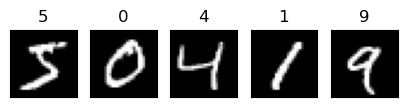

In [5]:
print(f"x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}")
print(f"x_train.min() = {x_train.min()}, x_train.max() = {x_train.max()}")
print(f"x_test.min() = {x_test.min()}, x_test.max() = {x_test.max()}")
print(f"y_train.min() = {y_train.min()}, y_train.max() = {y_train.max()}")
print(f"y_test.min() = {y_test.min()}, y_test.max() = {y_test.max()}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(5, 1))
for i in range(5):
    axs[i].imshow(x_train[i], cmap="gray")  
    axs[i].set_title(f"{y_train[i]}")
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)    
plt.show()

Подивимось на розподіл наших данних в трейні та тесті.

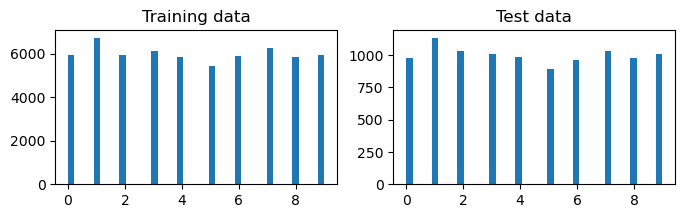

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 2))

ax1.hist(y_train, bins=40)
ax1.set_title("Training data")
ax2.hist(y_test, bins=40)
ax2.set_title("Test data")

plt.show()

Як бачимо розподіл більш-менш справедливий.

In [7]:
# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# При ітерації по train_data буде повертати випадкову вибірку із batch_size картинок   
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

print("Shuffled data:")
for sample in train_data.take(2):
    print(sample[1][:5].numpy())

Shuffled data:
[9 4 2 4 0]
[7 2 8 8 2]


In [8]:
# Создадим нейронную сеть
# добавимо в конструктор функцію активації яка за замовчуванням буде сигмоїдою
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, activation=tf.nn.sigmoid, name=None):
        super().__init__(name=name)
        
        self.w = tf.Variable(tf.random.normal([in_features, out_features], stddev=0.05), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.activation = activation
        
    def __call__(self, x):
        return self.activation(x @ self.w + self.b)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
    
        self.layers = [DenseLayer(in_features=num_features, out_features=n_hidden_1)]
        self.layers.append(DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2))
        self.layers.append(DenseLayer(in_features=n_hidden_2, out_features=num_classes, activation=tf.nn.softmax))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(
        tf.argmax(y_pred, 1), 
        tf.cast(y_true, tf.int64)
    )
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)


In [10]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y, optimizer=tf.optimizers.SGD):
    optimizer = optimizer(learning_rate)

    # Активация автоматического дифференцирования
    with tf.GradientTape() as g:
        pred = nn(input_x)
        loss = cross_entropy(pred, output_y)

        gradients = g.gradient(loss, nn.variables)
        optimizer.apply_gradients(zip(gradients, nn.variables))
        
    return pred

In [11]:
# Тренировка сети

loss_history = []
accuracy_history = []
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    pred = train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        loss_history.append(cross_entropy(pred, batch_y).numpy())
        accuracy_history.append(accuracy(pred, batch_y).numpy())

In [12]:
print(f"Last loss: {loss_history[-1]}")     
print(f"Last accuracy: {accuracy_history[-1]}")        

Last loss: 69.65465545654297
Last accuracy: 0.93359375


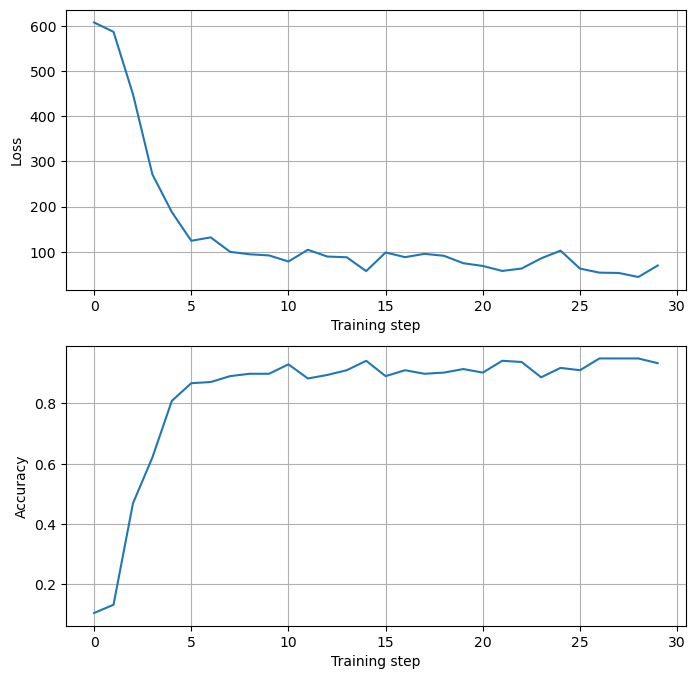

In [13]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

ax1.plot(loss_history)
ax1.set_xlabel("Training step")
ax1.set_ylabel("Loss")
ax1.grid()

ax2.plot(accuracy_history)
ax2.set_xlabel("Training step")
ax2.set_ylabel("Accuracy")
ax2.grid()

plt.show()

In [14]:
# Вычислите точность обученной нейросети
pred_test = neural_net(x_test)
acc_test = accuracy(pred_test, y_test).numpy()
print(f"Точність по всьому тестовому датасеті: {acc_test}")

# Проведемо тестування мережі на 100 пакетах тестових данних та виведемо середню точність по пакету
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

accuracy_list = []
BATCH_N = 100

for batch_x, batch_y in test_data.take(BATCH_N):
    pred_test = neural_net(batch_x)
    accuracy_list.append(accuracy(pred_test, batch_y).numpy())
print(f"Середня точність по тестовому пакету: {np.array(accuracy_list).mean()}")

Точність по всьому тестовому датасеті: 0.9365000128746033
Середня точність по тестовому пакету: 0.9350000023841858


Pred.: [8 1 1 6 8 5 6 0 7 0]
True.: [8 1 1 6 8 5 6 0 3 0]
Accuracy: 0.8999999761581421


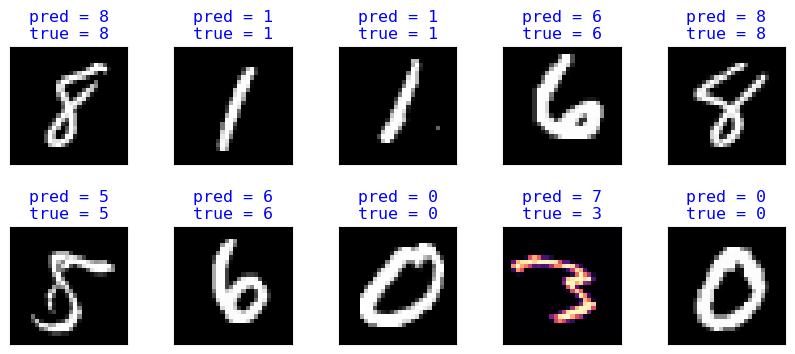

In [16]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

sample_idx = np.random.choice(range(len(x_test)), size=10, replace=False)

sample_x = x_test[sample_idx]
sample_y = y_test[sample_idx]

pred_test = neural_net(sample_x)
pred_y = tf.argmax(pred_test, axis=1)

print(f"Pred.: {np.array(pred_y)}")
print(f"True.: {sample_y}")
print(f"Accuracy: {accuracy(pred_test, sample_y).numpy()}")

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 4),
                        gridspec_kw={"wspace": 0.4, "hspace": 0.4})

colors = ["gray", "magma"]
title_font = {"family":"monospace", "color":"blue", "size":12}
for i, ax in enumerate(axs.flat):
    ax.imshow(sample_x[i].reshape(28,28) * 255, cmap=colors[int(pred_y[i] != sample_y[i])])  
    ax.set_title(f"pred = {pred_y[i]}\ntrue = {sample_y[i]}", fontdict=title_font)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
    
plt.show()

### Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

Ех, постановка питання натякає, що якомусь щасливчику вдасться побудувати нейромережу зі 100 процентним результатом. У мене ж на вибірці 10 000 нейромережа помилилась 635 разів. Або як в тирі вибила 94 зі 100 (точність - 0.9365). Що на мою думку досить непогано. Для більш детального розуміння побудуємо матрицю помилок нашої тестової вибірки.

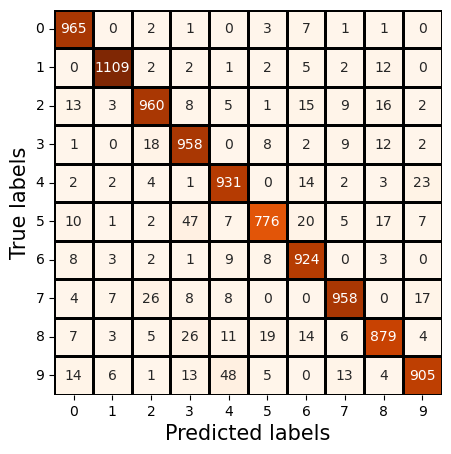

In [17]:
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

pred_test = neural_net(x_test)
y_pred = tf.argmax(pred_test, axis=1)

cm = confusion_matrix(y_test, y_pred)
df_confusion_matrix = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(5, 5))
sn.heatmap(df_confusion_matrix, fmt="d", annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel("True labels", fontsize=15)
plt.yticks(fontsize=10, rotation=0);

А також підрахуємо точність по кожній цифрі з нашої тестової вибірки. 

In [18]:
true_idx = np.where(y_test == y_pred)[0]
all_data = pd.DataFrame(y_test.reshape(-1,1), columns=["Num"]).groupby("Num")["Num"].count()
true_data = pd.DataFrame(y_test[[true_idx ]].reshape(-1,1), columns=["Num"]).groupby("Num")["Num"].count() 
accuracy_data = pd.DataFrame({"all_cnt": all_data, "true_cnt": true_data})
accuracy_data["accuracy"] = accuracy_data["true_cnt"] / accuracy_data["all_cnt"]
display(accuracy_data.sort_values("accuracy"))

,all_cnt,true_cnt,accuracy
Num,,,
5,892,776,0.869955
9,1009,905,0.896928
8,974,879,0.902464
2,1032,960,0.930233
7,1028,958,0.931907
4,982,931,0.948065
3,1010,958,0.948515
6,958,924,0.964509
1,1135,1109,0.977093


Як бачимо в нашій нейромережі  найбільші проблеми в п'ятірки з трійкою та в дев'ятки з четвіркою. Але були й інші результати в процесі тестування.

### Висновки.
__Побудована на запропонованих гіпер-параметрах нейромережа непогано справилася з завданням розпізнавання рукописних цифр з точністю 94 відсотка.__
- Впевнений, що реалізувавши оптимізацію по гіпер-параметрам можна досягнути і кращого результату.
- Матриця помилок справляє враження дуже гарного інструменту для аналізу помилок нейромережі.
- Було б дуже гарно, якщо ми б завжди до кінця курсу і на проєкті мали гарні вихідні данні, як і цього разу.
- Підхід лектора на леції сподобався більше чим запропонований в цьому ноутбуці.
- Було б непогано ще поглянути з якою вірогідністю перемагає неправильна класифікація. Але ця думка, нажаль, прийшла тільки при написанні висновків.